In [67]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from metpy.plots import USCOUNTIES
from datetime import datetime, timedelta
from netCDF4 import num2date
from siphon.catalog import TDSCatalog
import scipy.ndimage as ndimage

In [68]:
def get_gfs_data(url):
    best_gfs = TDSCatalog(url)
    best_ds = best_gfs.datasets[0]
    ncss = best_ds.subset()
    
    query = ncss.query()
    query.lonlat_box(north=55, south=20, east=300, west=220)
    query.accept('netcdf')
    query.variables('Geopotential_height_isobaric')
    query.vertical_level(50000)

    data = ncss.get_data(query)
    
    height_var = data['Geopotential_height_isobaric']
    time_var = data['time']
    lat_var = data['lat']
    lon_var = data['lon']

    height_vals = height_var[:].squeeze()
    lat_vals = lat_var[:].squeeze()
    lon_vals = lon_var[:].squeeze()
    time_vals = num2date(time_var[:].squeeze(), time_var.units)

    lon_2d, lat_2d = np.meshgrid(lon_vals, lat_vals)
    
    return lon_2d, lat_2d, height_vals, time_vals

def plot_on_map(lon_2d, lat_2d, data_diff, title):
   mapcrs = ccrs.LambertConformal(central_longitude=-98, central_latitude=39)  
   datacrs = ccrs.PlateCarree() 
   fig = plt.figure(figsize=(18,12)) 
   ax = fig.add_subplot(1, 1, 1, projection=mapcrs) 
   ax.set_extent([-120, -75, 25, 50], datacrs) 
   ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=2)
   ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25, alpha = 0.5)
   contour = plt.contour(lon_2d, lat_2d, ndimage.gaussian_filter(data_diff, sigma=2, order=0), levels=range(-150, 151, 10), transform=ccrs.PlateCarree(), colors='black', linewidths=0.5)
   ax.clabel(contour, fontsize=12, inline=1, inline_spacing=4, fmt='%i')
   contourf = plt.contourf(lon_2d, lat_2d, ndimage.gaussian_filter(data_diff, sigma=2, order=0), levels=range(-150, 151, 10), transform=ccrs.PlateCarree(), cmap='coolwarm', linewidths=2)
   cbar = plt.colorbar(contourf, ax=ax, orientation='horizontal', pad=0, aspect=50, shrink=0.85)
   cbar.set_label('Geopotential Height Difference (m)')
   plt.title('GFS 500MB: Geopotential Height Difference (m)', loc='left')
   plt.title(f'Valid: {title}', loc='right')
   plt.show()
   #plt.savefig(filename)
   #plt.close()
   

In [69]:
urls = [
    'https://www.ncei.noaa.gov/thredds/catalog/model-gfs-003-files/202305/20230501/catalog.html?dataset=gfs-g3-files/202305/20230501/gfs_3_20230501_0000_000.grb2',
    'https://www.ncei.noaa.gov/thredds/catalog/model-gfs-003-files/202305/20230501/catalog.html?dataset=gfs-g3-files/202305/20230501/gfs_3_20230501_0600_000.grb2',
    'https://www.ncei.noaa.gov/thredds/catalog/model-gfs-003-files/202305/20230501/catalog.html?dataset=gfs-g3-files/202305/20230501/gfs_3_20230501_1200_000.grb2',
    'https://www.ncei.noaa.gov/thredds/catalog/model-gfs-003-files/202305/20230501/catalog.html?dataset=gfs-g3-files/202305/20230501/gfs_3_20230501_1800_000.grb2',
    'https://www.ncei.noaa.gov/thredds/catalog/model-gfs-003-files/202305/20230502/catalog.html?dataset=gfs-g3-files/202305/20230502/gfs_3_20230502_0000_000.grb2',
    'https://www.ncei.noaa.gov/thredds/catalog/model-gfs-003-files/202305/20230502/catalog.html?dataset=gfs-g3-files/202305/20230502/gfs_3_20230502_0600_000.grb2',
    'https://www.ncei.noaa.gov/thredds/catalog/model-gfs-003-files/202305/20230502/catalog.html?dataset=gfs-g3-files/202305/20230502/gfs_3_20230502_1200_000.grb2',
    'https://www.ncei.noaa.gov/thredds/catalog/model-gfs-003-files/202305/20230502/catalog.html?dataset=gfs-g3-files/202305/20230502/gfs_3_20230502_1800_000.grb2',
    'https://www.ncei.noaa.gov/thredds/catalog/model-gfs-003-files/202305/20230503/catalog.html?dataset=gfs-g3-files/202305/20230503/gfs_3_20230503_0000_000.grb2']


In [70]:
height_var = data['Geopotential_height_isobaric']
time_var = data['time']
lat_var = data['lat']
lon_var = data['lon']

height_vals = height_var[:].squeeze()
lat_vals = lat_var[:].squeeze()
lon_vals = lon_var[:].squeeze()
time_vals = num2date(time_var[:].squeeze(), time_var.units)

lon_2d, lat_2d = np.meshgrid(lon_vals, lat_vals)

In [71]:
lon_2d_list = []
lat_2d_list = []
height_vals_list = []
time_vals_list = []

for url in urls:
    lon_2d, lat_2d, height_vals, time_vals = get_gfs_data(url)
    lon_2d_list.append(lon_2d)
    lat_2d_list.append(lat_2d)
    height_vals_list.append(height_vals)
    time_vals_list.append(time_vals)

In [72]:
differences_list = []

specific_url_names = [
    ("5/1 06z", "5/1 00z"),
    ("5/1 12z", "5/1 06z"),
    ("5/1 18z", "5/1 12z"),
    ("5/2 00z", "5/1 18z"),
    ("5/2 06z", "5/2 00z"),
    ("5/2 12z", "5/2 06z"),
    ("5/2 18z", "5/2 12z"),
    ("5/3 00z", "5/2 18z")]

for i in range(len(urls)-1):
    lon_2d_1, lat_2d_1, height_vals_1, time_vals_1 = lon_2d_list[i], lat_2d_list[i], height_vals_list[i], time_vals_list[i]
    lon_2d_2, lat_2d_2, height_vals_2, time_vals_2 = lon_2d_list[i+1], lat_2d_list[i+1], height_vals_list[i+1], time_vals_list[i+1]
    height_diff = height_vals_2 - height_vals_1
    differences_list.append(height_diff)

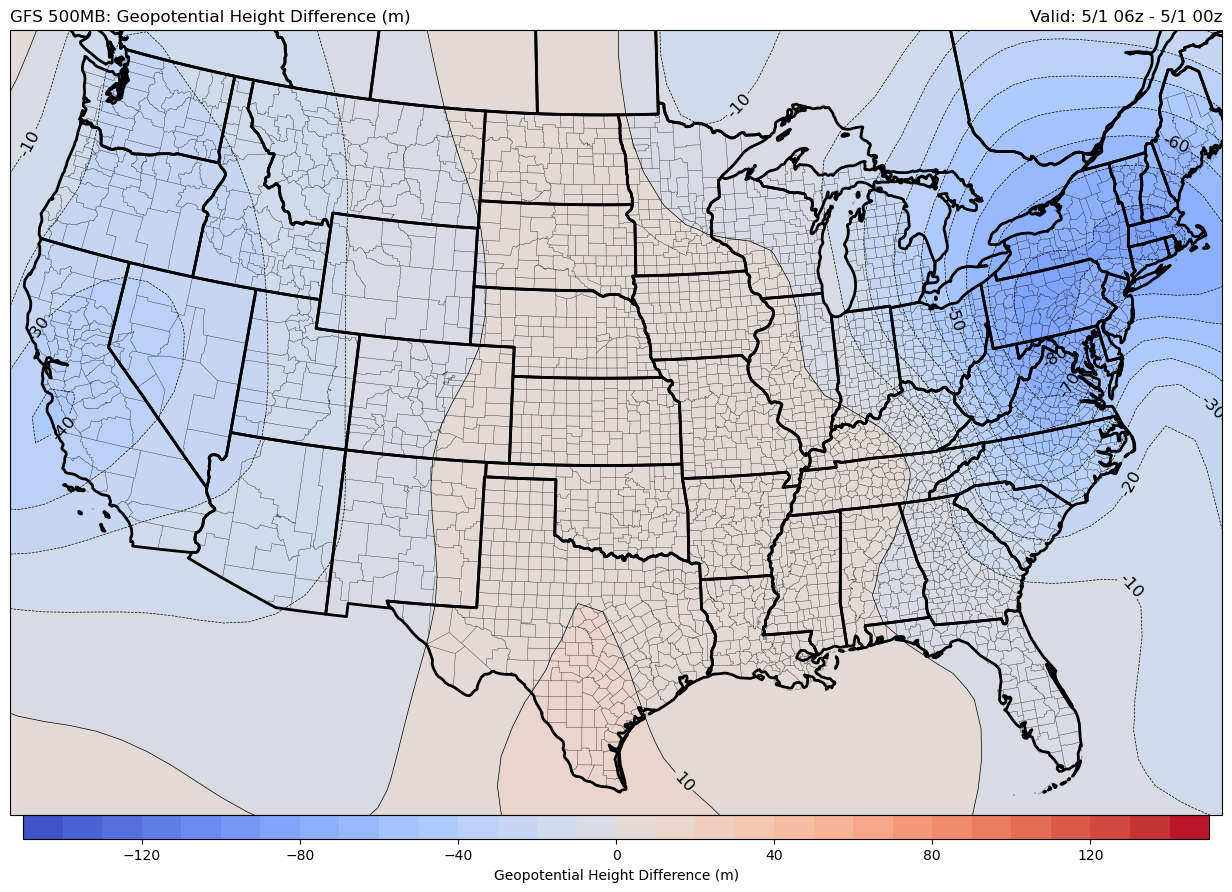

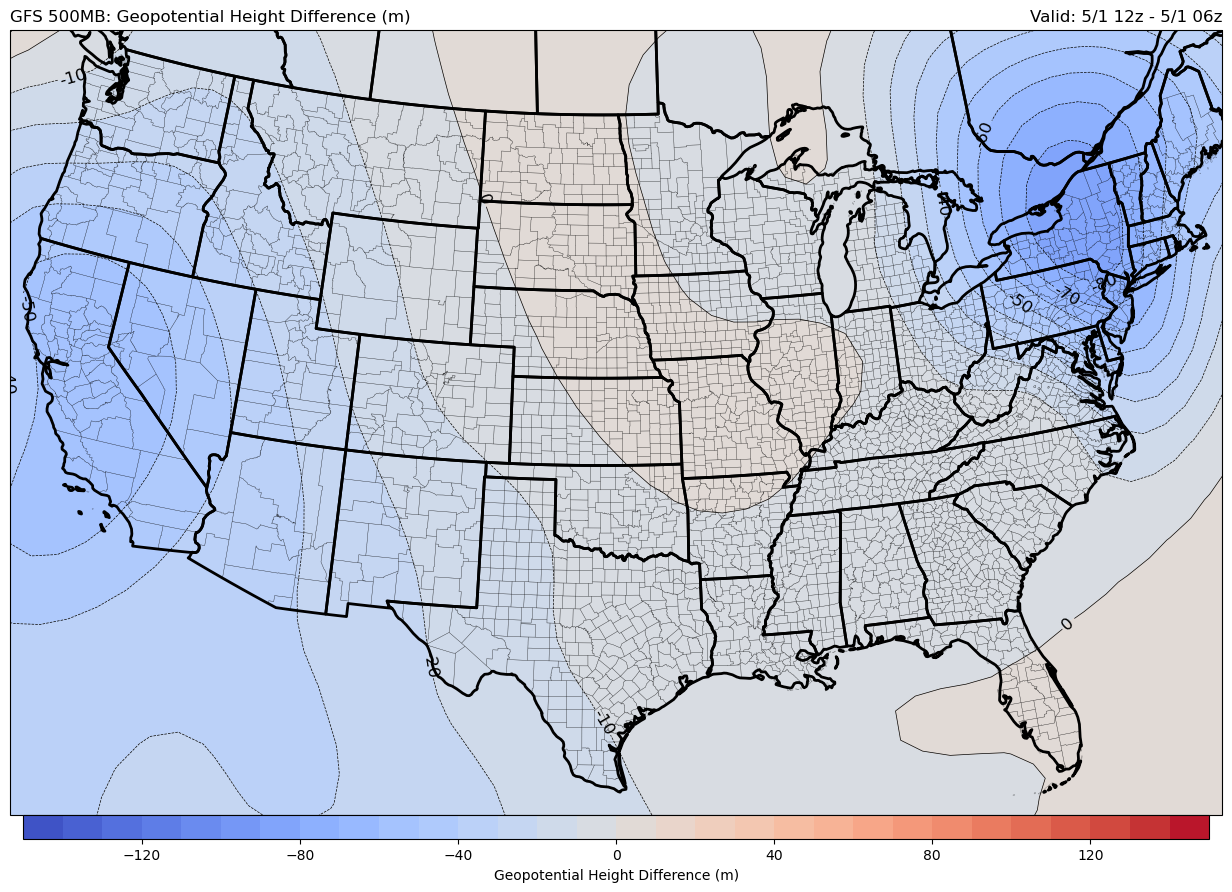

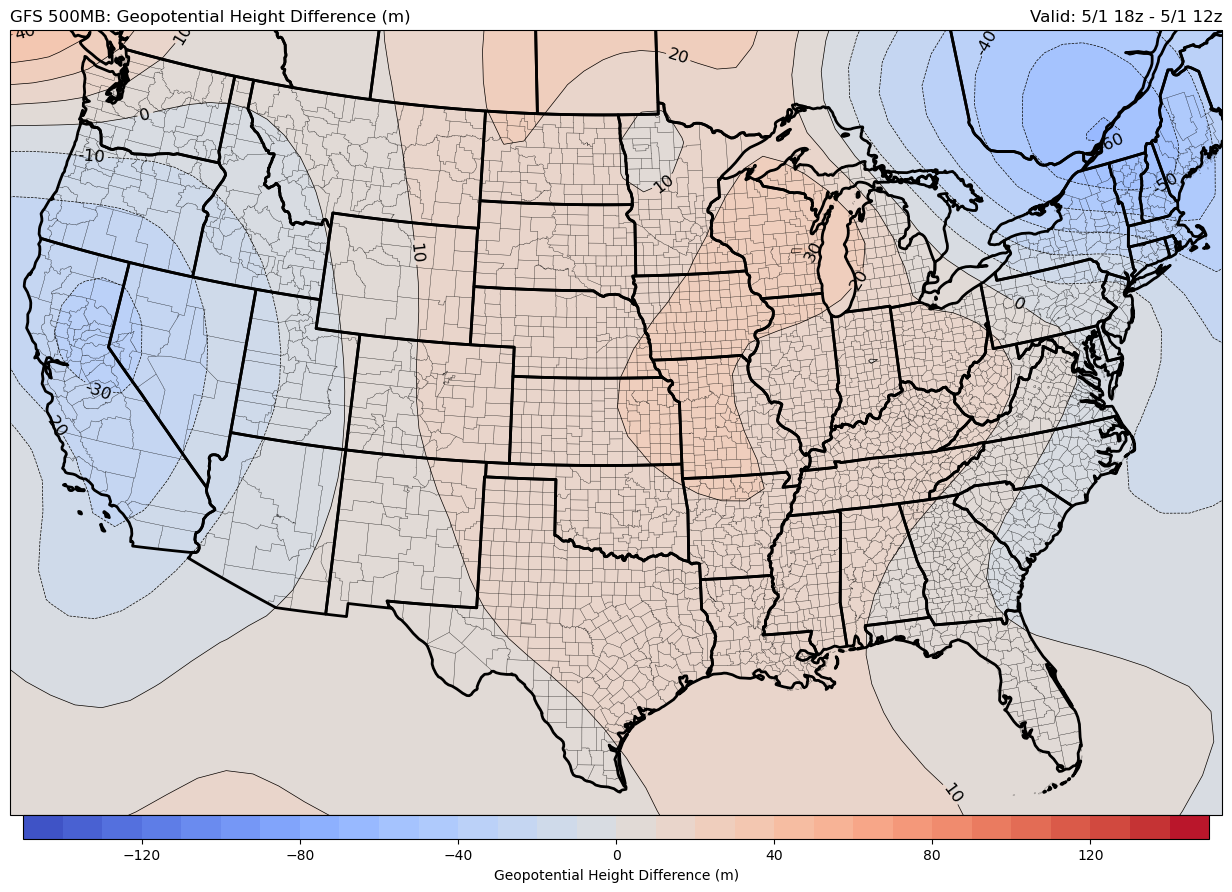

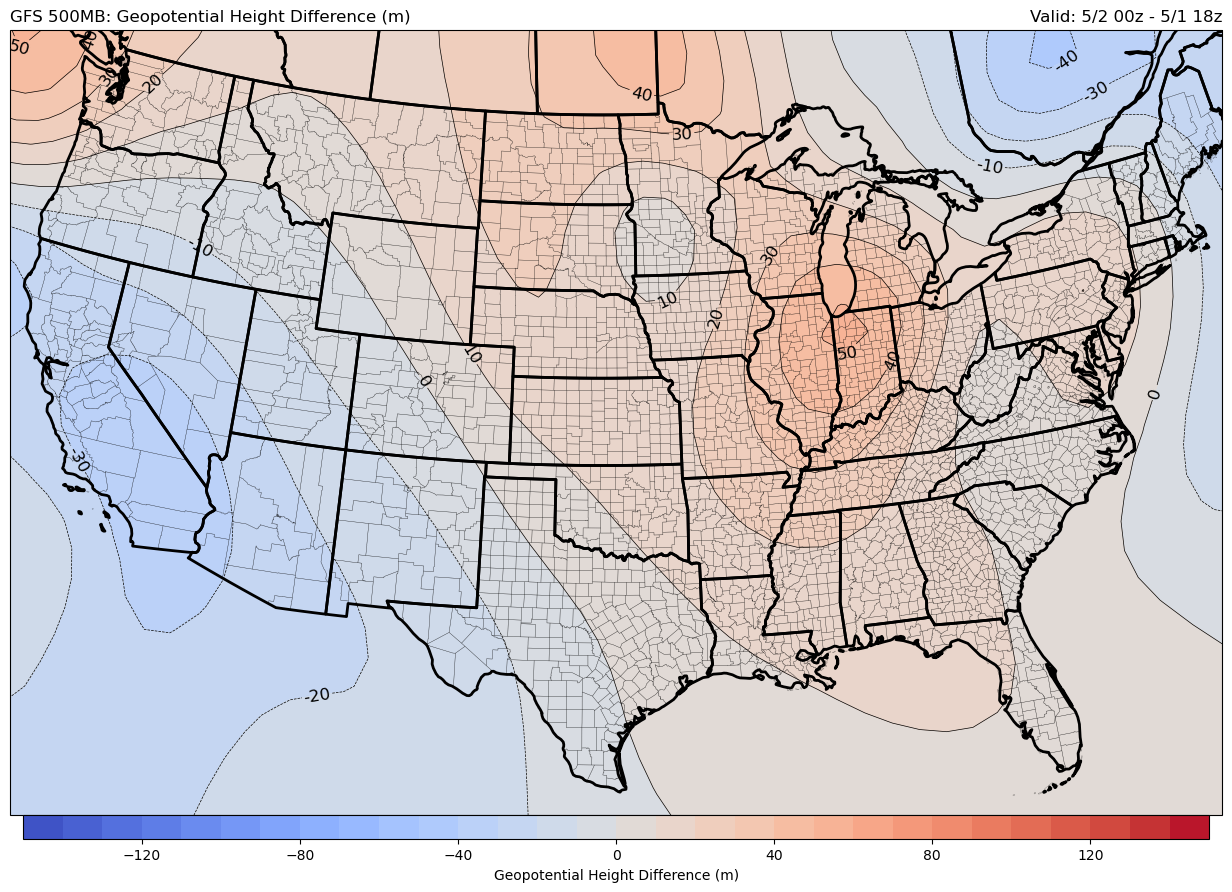

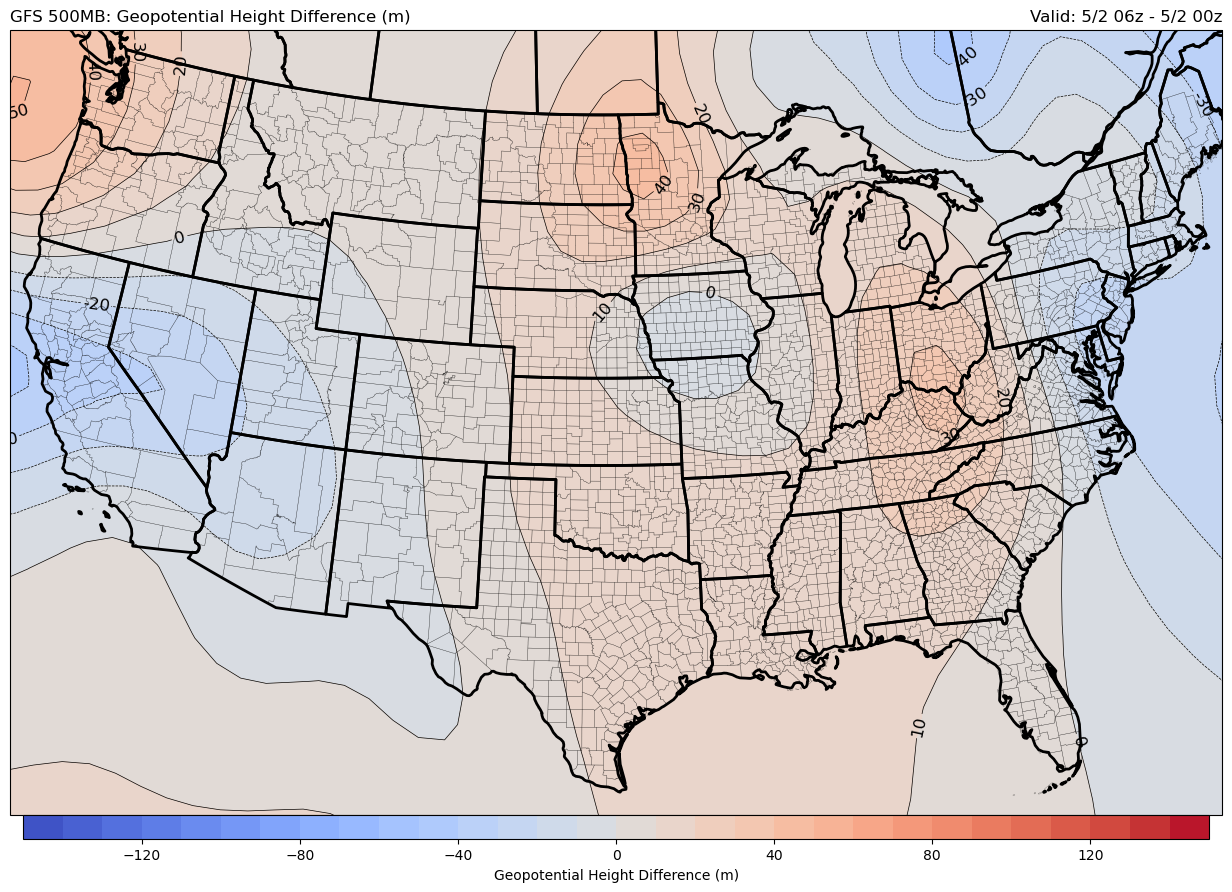

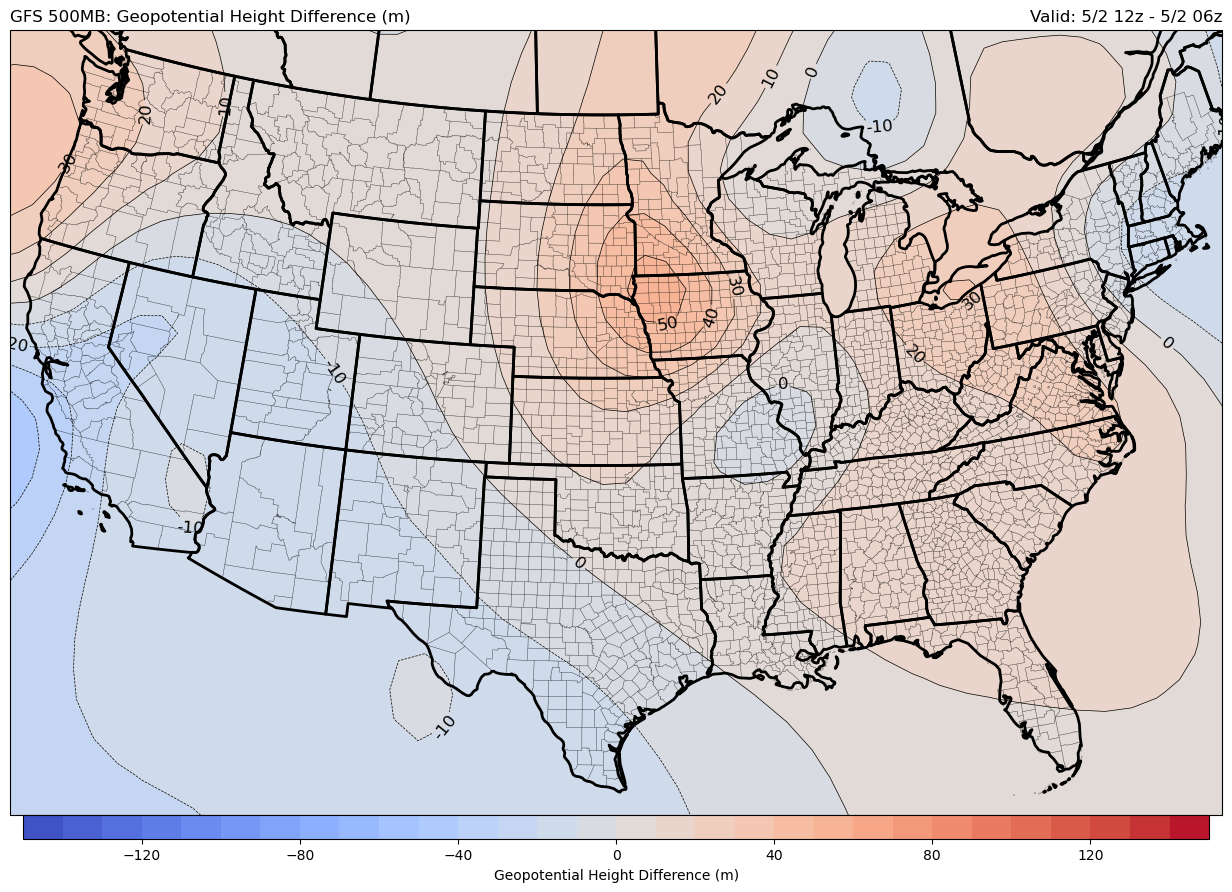

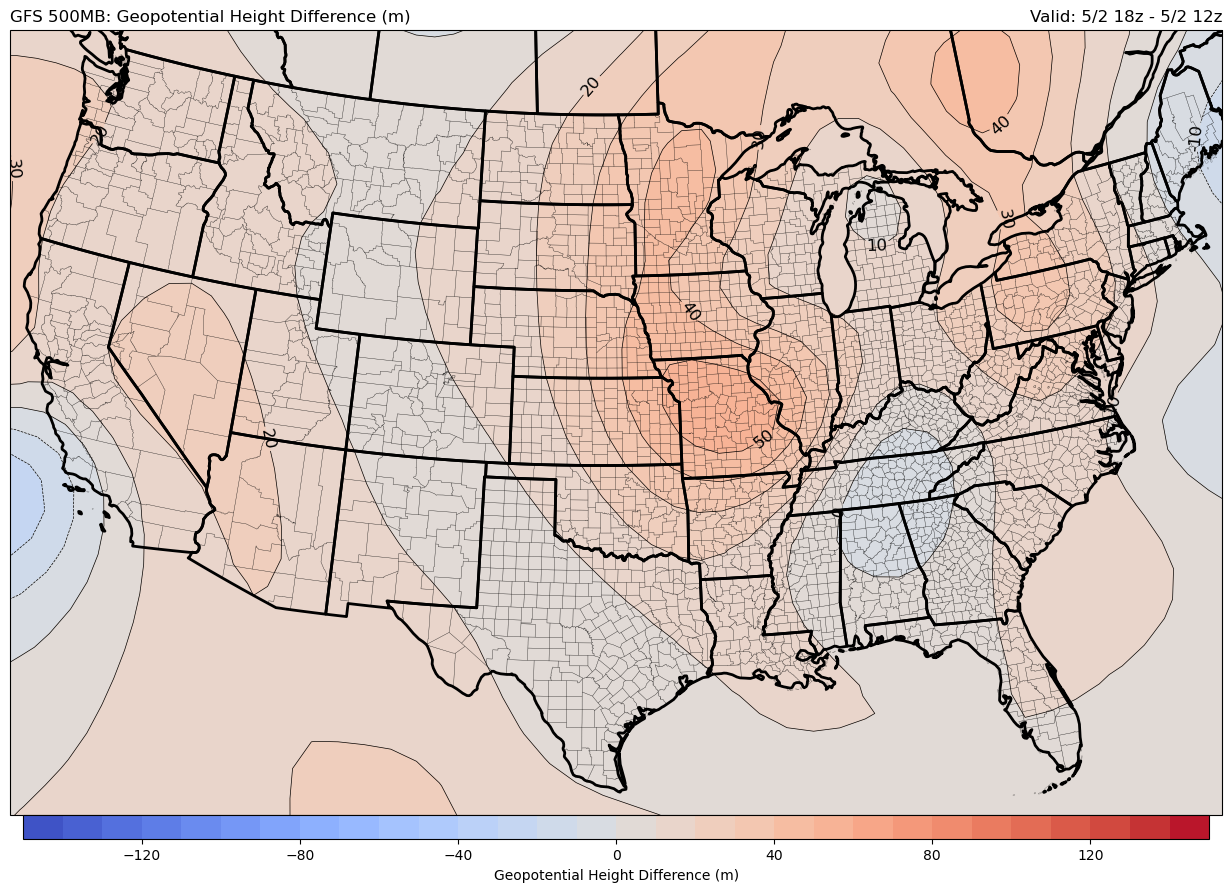

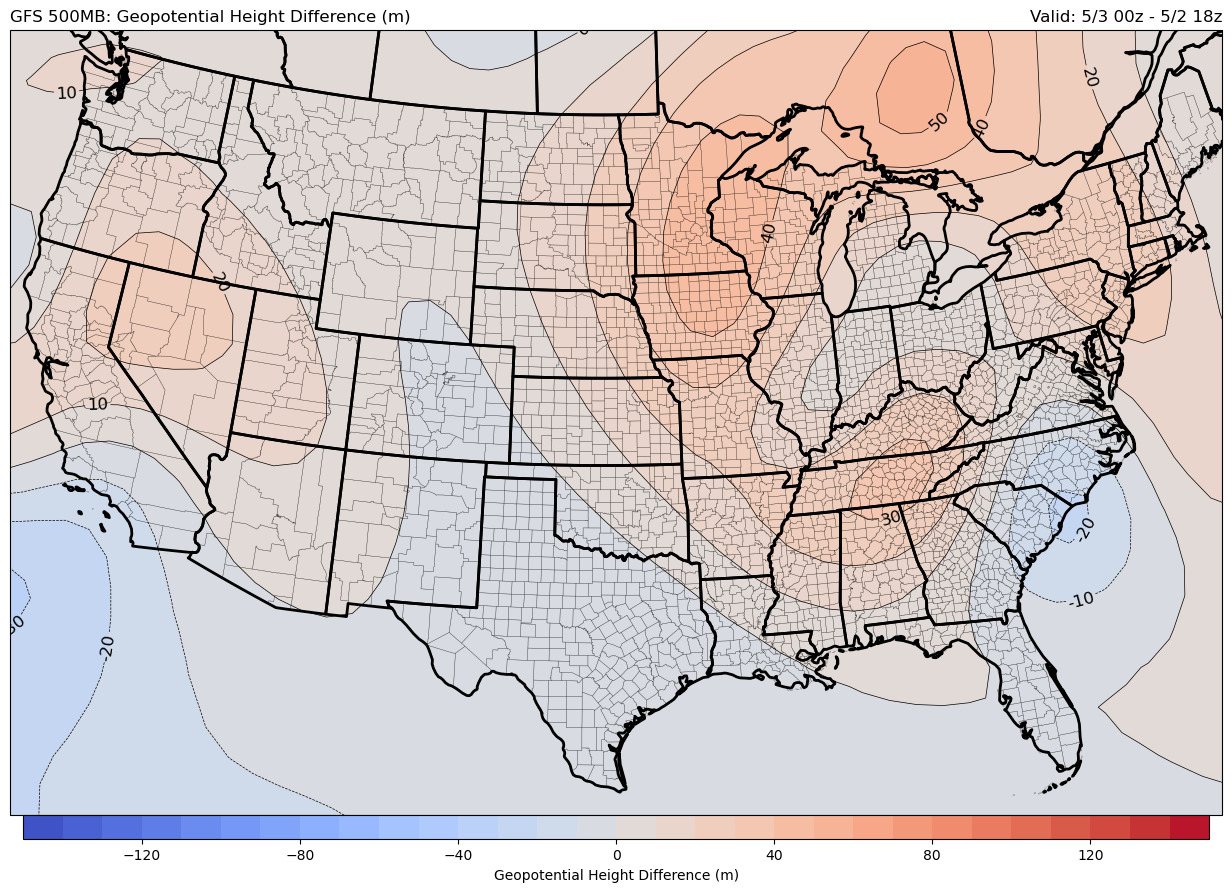

In [73]:
for i, (height_diff, (end_time, start_time)) in enumerate(zip(differences_list, specific_url_names)):
    lon_2d, lat_2d = lon_2d_list[i], lat_2d_list[i]
    title = f"{end_time} - {start_time}"
    plot_on_map(lon_2d, lat_2d, height_diff, title)